# Predicting Pitch Performance in Baseball with MLB Statcast Data

**Introduction**

Even at professional baseballs highest level, some pitcher are simply much better than others. What is more interesting yet is that even among a single pitchers arsenal of fastballs (balls pitched with a high velocity), breaking pitches (balls that exibit sudden breaks in horizontal and vertical movement), and changeups (balls that mimic fastballs but with a deceptively slower velocities)- some pitch types are also better than others!

Since 2014- Major League Baseball has utilized radar and camera systems at every game to amass a fascinating dataset that tracks everything from pitch velocity, the spin rate of the pitched ball itself, the exit velocity of hit balls, and more. We can access this data to try and predict: given some data on a given pitcher's pitch type, how good can we expect it to be? 

In this notebook- we will compare two different regression techniques: Linear Regression, and Random Forest Regressor. Additionally- we'll utilize Ridge Regression with our Linear Regression model to see if it can benefit from some degree of regularization. 

In [147]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor 
from sklearn import linear_model

**Dataset**

We'll look at data for the 2018 season specifically (baseball circa the COVID-19 lockdown got a little strange and difficult to compare). We access this from a Kaggle [link](https://www.kaggle.com/datasets/s903124/mlb-statcast-data?select=Statcast_2018.csv) which has data sourced from MLB's website, [Baseball Savant](https://baseballsavant.mlb.com/).

This statcast data is on a pitch-by-pitch level, the metric that we want to project onto is on an at-bat (a batter vs. pitcher matchup that consists of a sequence of pitches)- so we will need to aggregate this data before fitting out model. 

**Variables** 

We'll look at 11 different features: 
1. `release_speed`: the velocity of the ball as it leaves the hand of the pitcher, in miles per hour.
2. `release_pos_x`: the horizontal level of the ball as it leaves the hand of the pitcher from the batter's perspective (left to right) in feet.
3. `release_pos_z`: the vertical level of the ball as it leaves the hand of the pitcher, in feet form the ground.
4. `pfx_x`: horizontal movement in feet from the batter's perspective.
5. `pfx_z`: vertical movement in feet from the batter's perspective. Generally, the more movement a pitch exhibits, the more difficult it is for the hitter to track and hit. 
6. `vx0`: in feet per second, the velocity in the x dimension at 50 feet from the batter (out of 60 feet, 6 inches).
7. `vy0`: in feet per second, the velocity in the y dimension at 50 feet from the batter.
8. `vz0`: in feet per second, the velocity in the z dimension at 50 feet from the batter.
9. `release_extension`: how far out from the designated pitching spot (the rubber) the pitcher's hand is when the ball is pitched- some pitchers are able to extend exceptionally far, which decreases the overall distance the ball travels to the batter, resulting in a higher relative velocity!
10. `release_spin_rate`: the spin rate of the pitch, in rotations per minute. Utilizing the [Magnus Effect](https://en.wikipedia.org/wiki/Magnus_effect), pitch delivered with a high rate of spin can exhibit unexpected movement, such as fastballs that seem to "float" to their target (a four-seam fastball), or breaking pitches that "break" sharply to the ground or side on the way to the batter. 
11. `spin_axis`: the axis in the 2D X-Z plane in degrees from 0 to 360. 90 degress would represent a ball rotating perfectly clockwise from the perspective of a batter, 270 would be perfectly counter-clockwise. In terms of pitch types, 180 would be pure backspin resulting in a ball with a few inches of "rise" compared to a typical pitch, and 0 would be pure front spin, resulting in a ball with a few inches of "drop" (a "curveball"). 





In [234]:
# data from MLB statcast, 2018 season
df = pd.read_csv('/Users/ajmart15/Downloads/statcast/Statcast_2018.csv')


df = df[['pitcher',     # we will be grouping by pitcher and pitch type in the next section- these
          'pitch_type', # will not be used as features
          'release_speed', 
          'release_pos_x', 
          'release_pos_z', 
          'pfx_x', 
          'pfx_z', 
          'vx0',
          'vy0',
          'vz0',
          'release_extension', 
          'release_spin_rate', 
          'spin_axis', 
          'woba_value', # this and the denom will be summed up to get our y values
          'woba_denom', 
          'events']] # this will be use to filter only to pitches that resulted in an outcome
                     # as opposed to pitches that only result in balls, strikes, foul balls etc. 


**Target Value**

In baseball, there are lots of ways to measure the effectiveness of a pitcher, but my favorite way its to ask, how good did opposing batters perform?

In this question, we also have many different ways to measure the effectiveness of a batter- such as batting average (how often the batter puts the ball in to play). Something that is nice about the Statcast dataset, is that when a pitch results in an event (such as a strike out, a ball put into play, walk, home run, etc) the pitch has an assigned value and denominator of 1, which can then be summed into a very effective batting metric, Weighted On-Base Average or `wOBA`. This is a somewhat complicated stat to explain, but in essense, it weights the different outcomes (a home run is a very positive outcome, while a strike out is a very negative outcome) in a way that distills a batters total offensive output in a single number.

For context, an excellent wOBA would be `.400`, an average is about `.320` and a poor one would be `.290` or less.

**Data Transformation**

1. We want to narrow our dataset to only pitches that are measurable- that is, only pitches that result in an event like a hit or out (and will have a corresponding `woba_value` and a `woba_denom` of 1). 

2. We then group all our pitches by pitcher and pitch type. For example, pitcher `Zac Gallen` throws a four-seam fast ball (`FF`), a cut fastball (`FC`), a changeup (`CH`), a slider (`SU`), and a curveball (`CU`). This would result in 5 rows in our final dataset. 

    **NOTE:** from this point on, I will denote references to these rows (pitcher / pitch type combination) as `PITCHES`.

3. For each of our variables, we will take the mean of the values being grouped, except for `pitcher` which we will `count` for a later step, and `woba_value` and `woba_denom` which we will sum. 

4. While pitchers generally only have a few pitches that they throw well enough to rely on, occasionaly a pitcher might throw an unusual or "junk" pitch out of desperation or the desire to be less predictable. This is fine, but sometimes results in small sample sizes which might make a pitch look especially good or bad on a rate basis. To try to control for this, we'll only consider `PITCHES` with `n` of 10 or more.


In [235]:
# we only want pitches that result in events and have a corresponding woba_value
df = df[~df['events'].isna()]

# we group by pitcher and then pitch_type
# we count pitcher to get 'n', sum the woba_values and _denom, and average the others
df = df.groupby(by=['pitcher','pitch_type']).agg({
    'pitcher': 'count',
    'release_speed': 'mean',
    'release_pos_x': 'mean', 
    'release_pos_z': 'mean', 
    'pfx_x': 'mean', 
    'pfx_z': 'mean', 
    'vx0': 'mean',
    'vy0': 'mean',
    'vz0': 'mean',
    'release_extension': 'mean', 
    'release_spin_rate': 'mean', 
    'spin_axis': 'mean' , 
    'woba_value': 'sum',
    'woba_denom': 'sum',
})

# we only want PITCHES that have 10 or more events
df = df[df.iloc[:,0] >= 10]


In [237]:
df.head()

pitcher  release_speed  release_pos_x  release_pos_z  \
pitcher pitch_type                                                         
112526  CH               69      80.737681      -1.510000       5.458406   
        FC               20      85.365000      -1.597500       5.534000   
        FF               87      89.878161      -1.176322       5.661609   
        FT              406      87.035961      -1.503300       5.419680   
        SL               46      80.834783      -1.554783       5.512174   

                       pfx_x     pfx_z       vx0         vy0       vz0  \
pitcher pitch_type                                                       
112526  CH         -1.147826  0.648551  4.390495 -117.297538 -2.648621   
        FC         -0.095500  1.087500  2.453385 -124.159343 -3.146604   
        FF         -0.668276  1.358966  3.967465 -130.575652 -4.429238   
        FT         -1.411108  0.633276  6.027715 -126.353424 -2.270275   
        SL          0.350217  0.093478  3.792424 -117.490789 -1.496714   

                    release_extension  release_spin_rate   spin_axis  \
pitcher pitch_type                                                     
112526  CH                   5.246377        1649.913043  240.724638   
        FC                   5.125000        2283.350000  184.400000   
        FF                   5.120690        2300.333333  205.793103   
        FT                   5.169212        2133.958128  245.768473   
        SL                   4.763043        2384.951220  105.173913   

                    woba_value  woba_denom  
pitcher pitch_type                          
112526  CH               33.15        69.0  
        FC                8.45        20.0  
        FF               24.80        87.0  
        FT              150.55       404.0  
        SL               14.80        46.0

**Data Transformation, Part 2**

5. To prepare the data set to be fit, we drop the `count(pitcher)` column, and set the result as our `X` (this is an extra step because we also have `pitcher` as an index, which pandas dislikes). 

6. `pitcher` and `pitch_type` also remain from the grouping as an index, which we reset using `reset_index()`.

7. We calculate `woba` and set it as our target value `y`.

8. We drop `pitcher`, `pitch_type`, `woba`, `woba_value`, and `woba_denom`.


In [ ]:
# drop count(pitcher) set result as X
X = df.iloc[:,1:]

# reset index
X = X.reset_index()

# calculate woba, set as our y. 
X['woba'] = X['woba_value'] / X['woba_denom']
y = X['woba']

# drop pitcher, pitch type, woba_value and _denom
X = X.drop(columns=['pitcher', 'pitch_type', 'woba', 'woba_value', 'woba_denom'])

In [244]:
X.head()

,release_speed,release_pos_x,release_pos_z,pfx_x,pfx_z,vx0,vy0,vz0,release_extension,release_spin_rate,spin_axis
0,80.737681,-1.510000,5.458406,-1.147826,0.648551,4.390495,-117.297538,-2.648621,5.246377,1649.913043,240.724638
1,85.365000,-1.597500,5.534000,-0.095500,1.087500,2.453385,-124.159343,-3.146604,5.125000,2283.350000,184.400000
2,89.878161,-1.176322,5.661609,-0.668276,1.358966,3.967465,-130.575652,-4.429238,5.120690,2300.333333,205.793103
3,87.035961,-1.503300,5.419680,-1.411108,0.633276,6.027715,-126.353424,-2.270275,5.169212,2133.958128,245.768473
4,80.834783,-1.554783,5.512174,0.350217,0.093478,3.792424,-117.490789,-1.496714,4.763043,2384.951220,105.173913


In [256]:
len(X)

2307

In [246]:
y.head()

0    0.480435
1    0.422500
2    0.285057
3    0.372649
4    0.321739
Name: woba, dtype: float64

**Data Transformation, Final**

9. Set `SEED`, split `X` and `y` into training and test sets (`.75` and `.25` respectively)

10. one of the models is sensitive to scale, so we run all our input values through a `StandardScaler()`.



In [ ]:
SEED = 432
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

**Modeling Data: Linear Model with Ridge**

First, we'll start off with a Linear Model: this should be a good baseline to compare other techniques against, and by using regularization- specifically Ridge regression, we might be able to see if get a little variable selection by shrinkage, which may be preferable since we have relatively few variables. We will try some values of `alpha` in decreasing complexity and see which one performs best. 

`sklearn` also has options out of the box to do cross-validation. Since our dataset is not very large (`n=2307`), we can actually set `cv=None` and direct `RidgeCV` to use Leave-One-Out as our CV strategy. 

We can then have `RidgeCV` output the `MSE` for all the cross-validations for each of the values of `alpha`, which we can then average together and decide on the best base on `RMSE`. 


In [274]:

# a few ranges of alpha
alpha_values = [.1, 1, 10, 1000]

model = linear_model.RidgeCV(
    alphas=alpha_values, # regularization coefficent
    cv=None, # defaults to LOOCV
    store_cv_values=True
)

model.fit(X_train, y_train)

# calculate RMSE for values of alpha
alpha_rmse = np.mean(model.cv_values_, axis=0)**(1/2)
for i, a in enumerate(alpha_rmse):
    print(f"alpha value: {alpha_values[i]}\t mean RMSE: {a}")


alpha value: 0.1	 mean RMSE: 0.10087703237325908
alpha value: 1	 mean RMSE: 0.10096388223504842
alpha value: 10	 mean RMSE: 0.10100898069748274
alpha value: 1000	 mean RMSE: 0.10258250229818094


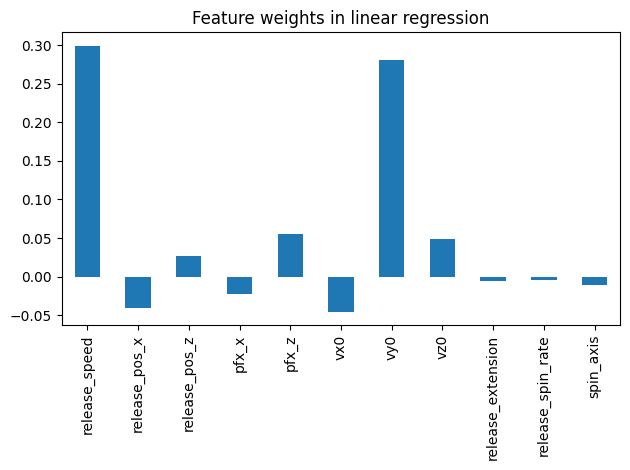

In [277]:
# display weights of fitted model 
model.coef_


forest_importances = pd.Series(model.coef_, index=list(X.columns))

# std = np.std([model.feature_importances_ for tree in model.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature weights in Linear Regression")
fig.tight_layout()

In [259]:
# display best regularization parameter
model.alpha_

0.1

In [260]:

y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)**(1/2)

print(f"alpha value: {model.alpha_}\t out-of-sample RMSE: {rmse}")

alpha value: 0.1	 out-of-sample RMSE: 0.09665857756082627


**Linear Model with Ridge, Conclusions**

Interestingly, we see that RidgeCV has chosen the lowest value, `alpha=0.1` as the winning regularization parameter- meaning that the most complex version of our model ended up performing the best (though the difference is quite small).

Examining the weights we see that `release_speed` is the biggest variable coefficient, followed closely by `vy0` - this makes sense, because `vy0` is basically the release_speed after traveling about 10ft of distance. On the other hand, the model puts little weight into `release_spin_rate`- much less than the corresponding `spin_axis`. This suggests that pure spin rate is perhaps less important than being able to spin pitches in a certain orientation, a potential new variable for a future version of the model.

Finally, we make our predictions on our test set and get the resulting RMSE- `0.096`. This seems fine as a starting point, but we can hope for potentail improvement with a different technique- an error value like this means that we're unsure if a `PITCH` is average (`.320`) or terrible (`.416`)!

**Modeling Data, Random Forest**

Now, we'll see if we can beat that performance by using a Random Forest. We'll use the standard `RandomForestRegressor` model and try a small range of estimators that determine the number of trees in the forest. Finally, we will predict our test set onto the fitted model- we expect that out-of-sample performance will be poor, but we can see if we can perform better than our linear model. 

In [262]:
est_values = [int(np.floor(np.exp(x * .8))) for x in range(2, 10)]

for e in est_values:
    model = RandomForestRegressor(n_estimators=e, random_state=SEED)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_train)

    rmse = mean_squared_error(y_train, y_pred)**(1/2)

    print(f"# of estimators: {e}\t out-of-sample RMSE: {rmse}")
    

# of estimators: 4	 out-of-sample RMSE: 0.05482351071122553
# of estimators: 11	 out-of-sample RMSE: 0.044901484244536674
# of estimators: 24	 out-of-sample RMSE: 0.04215418984010329
# of estimators: 54	 out-of-sample RMSE: 0.03942318620419858
# of estimators: 121	 out-of-sample RMSE: 0.038271946131819966
# of estimators: 270	 out-of-sample RMSE: 0.03766902159274282
# of estimators: 601	 out-of-sample RMSE: 0.037432506638280245
# of estimators: 1339	 out-of-sample RMSE: 0.037406923575448996


In [278]:
model = RandomForestRegressor(n_estimators=1339, random_state=SEED)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)**(1/2)

print(f"# of estimators: {1339}\t out-of-sample RMSE: {rmse}")
    

# of estimators: 1339	 out-of-sample RMSE: 0.09783785443009795


**Random Forest Regressor, Results**

After trying different values, we see that the greatest number for the number of estimators (`e=1339`) was the best performer, though it seems that after `e=270`, we see diminishing returns.

Running the fitted model on our test data, we get a worse performance on this out-of-sample data, as expected. In fact, our Random Forest actually underperforms our Linear Model slightly, falling victim to seemingly overfitting on our training set. 

Looking at our list of feature importances, we see an interest divergence from the findings of the Linear Regression. Our Random Forest model seems to think that vertical movement (`pfx_z`) is the most important feature, along with `release_extension` and `release_spin_rate`. Could it be that spin rates are related to vertical movement and thus, pitch performance? Or, is it more likely that some of these variables are assigned outsized weights, contributing to our problem of overfitting that seems to be dragging down the performance of the model. In the next iteration of this model, we would want to focus on introducing pruning and seeing if getting less complex could result in a more robust model. 

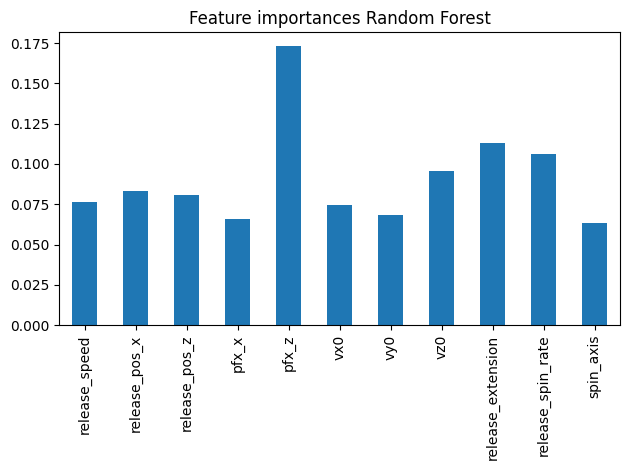

In [280]:

forest_importances = pd.Series(model.feature_importances_, index=list(X.columns))

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances Random Forest")
fig.tight_layout()

**Conclusions**

Comparing the two models, it's not difficult to conclude that with ability to achieve feature shrinkage, the Linear Regression model is the better performer. Looking at the feature importance in the Random Forest, we can see that almost all the features have relatively similar importance, making our model vulerable to outliers, especially with a smaller data set. 

Going forward, it would be exciting to explore some feature engineering, doing more EDA on spin rates, and deriving more patterns on release positioning, and potentailly including more columns from our original data source as worthy features. 

Model wise, we can see that the Random Forest Regressor has great potential, but needs to utilize some degree of pruning. Additionally, implementing a grid search to do hyperparameter tuning would be an effective improvement, representing a low-hanging fruit. 

**References**

Video of Kodai Senga demonstrating breaking pitches, via @PitchingNinja: https://www.youtube.com/watch?v=riJKj5_ZoNc

Baseball Savant example page: https://baseballsavant.mlb.com/illustrator?playerId=668678&playerType=pitcher&name=Zac%20Gallen&tabSelection=1&shape=square&shapeName=Square%20(Instagram)&subTitle=&chartType=pitchChart-pitchName&chartName=Pitch%20Types&pitcherThrows=&batterStands=&plateAppearanceResults=[]&pitchTypes=[]&seasonType=[%22R%22]&pitchResults=[]&facingPlayer=[]&balls=[]&battedBallType=[]&years=[2023]&strikes=[]&outs=[]&selectedGames=[%22717955%22]&homeTeam=[]&awayTeam=[]&vsTeam=[]&exitVelocityGT=0&exitVelocityLT=125&pitchVelocityGT=0&pitchVelocityLT=105&launchAngleGT=-90&launchAngleLT=90&perspective=catcher